### Data Challenge, Part 2

In [1]:
#!pip install catboost
#!pip install category_encoders

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier, CatBoostRegressor
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, r2_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Dataset
### 1a. Preprocessing

- After loading the provided sales data into pandas, I rounded the profit and sales columns to monetary format, and added another feature called `Ship Time`, the number of days a product took to ship, based on the `Order Date` and `Ship Date`. 
- To further simplify the dataset, I thought the following columns were worth excluding: `Country`, `City`, `Customer Name`, and `Product Name`. The only country in the dataset was United States, so `Country` does not distinguish any of the transactions. `Customer Name` and `Product Name` were also not needed, because we already have corresponding ID columns `Customer ID` and `Product ID`. Finally, I  thought `City` was not needed, since `Postal Code` basically represents the same thing and is numerical, and we also have enough geographical granularity with the `State` and `Region` columns for a 10,000 row dataset.

In [2]:
trans_df = pd.read_csv("../sales_data.csv", encoding='unicode_escape', index_col='Row ID', skipinitialspace=True)

# clean up data formats
trans_df['Profit'] = round(trans_df['Profit'], 2)
trans_df['Sales'] = round(trans_df['Sales'], 2)
trans_df['Order Date'] = pd.to_datetime(trans_df['Order Date'])
trans_df['Ship Date'] = pd.to_datetime(trans_df['Ship Date'])
trans_df['Ship Time'] = (trans_df['Ship Date'] - trans_df['Order Date']).dt.days

# drop less important columns
trans_df = trans_df.drop(columns=['Country', 'City', 'Customer Name', 'Product Name'])
print(trans_df.shape)
trans_df.head()

(9994, 17)


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,Ship Time
Row ID,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.96,2,0.00,41.91,3
2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.94,3,0.00,219.58,3
3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.62,2,0.00,6.87,4
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.58,5,0.45,-383.03,7
5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.37,2,0.20,2.52,7


### 1b. Numerical Feature Correlations

From the feature correlation matrix below, we observe the following three relationships, though none of them particularly strong:  

**Sales and Profit (+0.48)**: Not surprising, since a profitable item often has high sales. However, this correlation is weakened in the case of high-sales, high-cost items, or lower-sales, very low-cost items.

**Discount and Profit (-0.22)**: I suspected that there might be a bit of a correlation here, since often a store may have certain items on discount because they need to get rid of them quickly. Although the correlation is weak, I decided to explore this relationship further in the machine learning model to come. 

**Sales and Quantity (+0.20)**: Also not surprising that there's a hint of relationship, though there are too many examples of expensive single quantity transactions.

The `Ship Time` and `Postal Code` features did not correlate with any other numerical feature

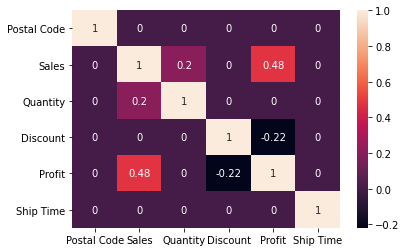

In [3]:
correlations = trans_df.corr()
correlations[np.abs(correlations) < 0.2] = 0
sns.heatmap(correlations, annot=True)
plt.show()

A negative relationship between discount and profit (-0.75) becomes apparent  when I express profit categorically, in a new feature called `Profitable`. It takes on a binary value, where 0 represents an unprofitable transaction and 1 represents a profitable one. When profit stays numerical, it probably weakens the corrrelation, since we were incorrectly imposing that a heavier discount results in a heavier loss linearly. In addition, discounts fall in a discrete range while profit is unbounded, so the constraints of these two features is different. With a `Profitable` column, a negative feedback caused by a discount is still retained, but we no longer have to assume a linear relation between the two features.

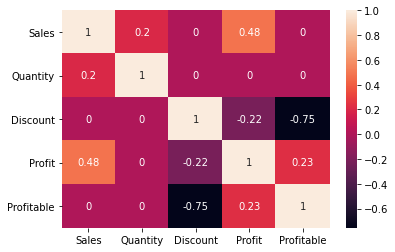

In [4]:
trans_df['Profitable'] = np.where(trans_df['Profit'] < 0, 0, 1)
correlations = trans_df.loc[:, ~trans_df.columns.isin(['Ship Time','Postal Code'])].corr()
correlations[np.abs(correlations) < 0.2] = 0
sns.heatmap(correlations, annot=True)
plt.show()

## 2. Profitability Model

With the relationship between `Discount` and `Profitable` established, I decided to train a machine learning model that predicts whether a transaction is profitable or not. 

### 2a. Base Model

For the training and testing sets, I usually stick with an 80-20 split. An interesting fact I came across is that this ratio is actually captured in the Pareto Principle, which states that about 80% of consequences come from 20% of causes. 

To train the model, I used Catboost, a gradient boosting decision tree library. In particular, I chose it over other alternatives like XGBoost and LightGBM because it has better support for categorical data. To avoid overfitting, I included another parameter `early_stopping_rounds`, which stops training the model if the validation results do not improve after a certain number of iterations. 

Using `Discount` as the only feature, here are the baseline results:  

**roc_auc score:** 0.85556  
**accuracy:** 94.35%  
821 True Unprofitable, 23 False Unprofitable, 4838 True Profitable, 314 False Profitable

In [5]:
Xb = trans_df[['Discount']]
yb = trans_df[['Profitable']]
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2)
Xb_test, Xb_val, yb_test, yb_val = train_test_split(Xb_train, yb_train, test_size=0.25)

Xb_train.shape, Xb_test.shape, yb_train.shape, yb_test.shape, Xb_val.shape, yb_val.shape

((7995, 1), (5996, 1), (7995, 1), (5996, 1), (1999, 1), (1999, 1))

In [6]:
base_model = CatBoostClassifier()
base_model.fit(Xb_train, yb_train, eval_set=(Xb_val, yb_val), early_stopping_rounds=10, verbose=0)

y_base_pred = base_model.predict(Xb_test)
roc_auc = roc_auc_score(yb_test, y_base_pred)
accuracy = accuracy_score(yb_test, y_base_pred)
print(f"roc_auc: {roc_auc:.5f}")
print(f"accuracy: {(accuracy*100):.2f}%")

tn, fp, fn, tp = confusion_matrix(yb_test, y_base_pred).ravel()
print(f"(True Unp, False P, False Unp, True P): {(tn, fp, fn, tp)}")

roc_auc: 0.85755
accuracy: 94.35%
(True Unp, False P, False Unp, True P): (803, 311, 28, 4854)


### 2b. Revised Model

Let's take a closer look at the categorical features to see if including any of them would improve the base model.  
Before that, categorical features need to be numerically-encoded to be useful in analysis. I considered one-hot encoding, frequency encoding, and CatBoost encoding.
- One-hot encoding is not suitable for this dataset as it increases dimensionality too much. We would need 49 new columns to encode just the `State` feature, and 16 new columns for `Sub-Category` feature!
- Frequency encoding appeared to be a viable alternative, where the encoding depends on how many times a category appears in the column. However, it is problematic when multiple encodings appear the same amount of times. When this happens, the features melt together into one and we lose valuable information about the dataset. 
- Ultimately, I choose to stick with CatBoost's default encoding, which is similar to encoding categorical features based on information about the target variable. It also does not add any dimensionality to the data.

In [7]:
cat_cols = ['Ship Mode', 'Segment', 'State', 'Product ID', 'Category', 'Sub-Category', 'Region', 'Customer ID', 'Postal Code']
encoder = ce.CatBoostEncoder(cols=cat_cols)
encoder.fit(trans_df.loc[:, trans_df.columns != 'Profitable'], trans_df['Profitable'])

trans_df_enc = encoder.transform(trans_df.loc[:, trans_df.columns != 'Profitable'])
trans_df_enc['Profitable'] = trans_df['Profitable']
trans_df_enc.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,Ship Time,Profitable
Row ID,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,0.842144,0.802131,0.806782,0.998663,0.996179,0.840107,0.562558,0.663437,0.523200,261.96,2,0.00,41.91,3,1
2,CA-2016-152156,2016-11-08,2016-11-11,0.842144,0.802131,0.806782,0.998663,0.996179,0.840107,0.985599,0.663437,0.619438,731.94,3,0.00,219.58,3,1
3,CA-2016-138688,2016-06-12,2016-06-16,0.842144,0.581279,0.815893,0.947459,0.965958,0.900691,0.976598,0.852964,0.999487,14.62,2,0.00,6.87,4,1
4,US-2015-108966,2015-10-11,2015-10-18,0.803453,0.800799,0.806782,0.671387,0.613299,0.840107,0.423643,0.663437,0.365040,957.58,5,0.45,-383.03,7,0
5,US-2015-108966,2015-10-11,2015-10-18,0.803453,0.800799,0.806782,0.671387,0.613299,0.840107,0.968798,0.852964,0.809696,22.37,2,0.20,2.52,7,1


Now, let's take a look a more detailed correlation matrix incorporating all the encoded categorical features and `Profitable`. Since the `Ship Mode`, `Segment`, and `Quantity` features did not have a correlation above 0.3 to any other variable, I dropped them to reduce some dimensionality. Here were some meaningful relationships not apparent before:

**Discount and State (-0.70)**: This one surprised me the most, as logically it seems that discounts should be  randomly-dispersed by state. I decided to create a model using the `Discount` feature in the following section.

Features related to `Profitable`: **Product ID and Profitable (+0.63)**, **State and Profitable (+0.52)**, and **Sub-Category and Profitable (+0.44)**  

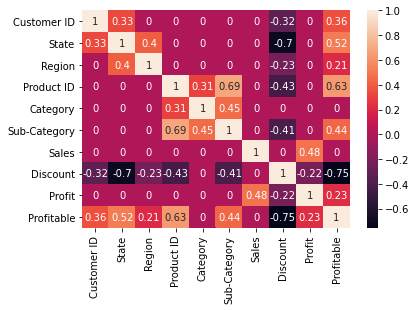

In [8]:
correlations = trans_df_enc.loc[:, ~trans_df_enc.columns.isin(['Ship Time','Postal Code', 'Ship Mode', 'Segment', 'Quantity'])].corr()
correlations[np.abs(correlations) < 0.2] = 0
sns.heatmap(correlations, annot=True)
plt.show()

`Product ID`, `State`, and `Sub-category` are all important features for us to determine profitability of a transaction. First, I only added `Product ID` to the model. The performance improved a lot, with accuracy consistently topping 99.5% and roc-auc score being almost 1. This was more than enough, since adding a third feature, `State` or `Sub-Category`, leads to no improvements and the validation results start getting worse after a smaller number of iterations, meaning that it is more prone to overfitting.

In [9]:
X_rev = trans_df[['Discount','Product ID']]
y_rev = trans_df[['Profitable']]
X_rev_train, X_rev_test, y_rev_train, y_rev_test = train_test_split(X_rev, y_rev, test_size=0.2)
X_rev_test, X_rev_val, y_rev_test, y_rev_val = train_test_split(X_rev_train, y_rev_train, test_size=0.25)

X_rev_train.shape, X_rev_test.shape, y_rev_train.shape, y_rev_test.shape, X_rev_val.shape, y_rev_val.shape

((7995, 2), (5996, 2), (7995, 1), (5996, 1), (1999, 2), (1999, 1))

In [10]:
fin_model = CatBoostClassifier()
fin_model.fit(X_rev, y_rev, cat_features=['Product ID'], eval_set=(X_rev_val, y_rev_val), verbose=0)

y_pred = fin_model.predict(X_rev_test)
roc_auc = roc_auc_score(y_rev_test, y_pred)
accuracy = accuracy_score(y_rev_test, y_pred)
print(f"roc_auc: {roc_auc:.5f}")
print(f"accuracy: {(accuracy*100):.2f}%")

tn, fp, fn, tp = confusion_matrix(y_rev_test, y_pred).ravel()
print(f"(True Unp, False P, False Unp, True P): {(tn, fp, fn, tp)}")

roc_auc: 0.99768
accuracy: 99.90%
(True Unp, False P, False Unp, True P): (1124, 5, 1, 4866)


## 3. Discount Model

Seeing that the transaction discount correlated to many other features in the dataset, I decided to create a regression model that would predict the amount of discount applied on a given transaction. By simply using the features with highest correlation to `Discount` from the matrix, the model outputs nearly perfect predictions. 

**r-squared:** 0.9933, **rmse:** 0.0003

In [11]:
X_disc = trans_df[['Profitable','Sub-Category', 'State']]
y_disc = trans_df[['Discount']]
X_disc_train, X_disc_test, y_disc_train, y_disc_test = train_test_split(X_disc, y_disc, test_size=0.2)
X_disc_test, X_disc_val, y_disc_test, y_disc_val = train_test_split(X_disc_train, y_disc_train, test_size=0.25)

X_disc_train.shape, X_disc_test.shape, y_disc_train.shape, y_disc_test.shape

((7995, 3), (5996, 3), (7995, 1), (5996, 1))

In [12]:
disc_model = CatBoostRegressor(n_estimators=1500, depth=4, l2_leaf_reg=0.001, early_stopping_rounds=10, verbose=0)
disc_model.fit(X_disc, y_disc, eval_set=(X_disc_val, y_disc_val), cat_features=['Sub-Category', 'State'])

y_disc_pred = np.round(disc_model.predict(X_disc_test), 2)
r2 = r2_score(y_disc_test, y_disc_pred)
rmse = mean_squared_error(y_disc_test, y_disc_pred)
print(f"r^2: {r2:.4f}")
print(f"rmse: {rmse:.4f}")

r^2: 0.9926
rmse: 0.0003


### 4. Sub-Category Model

### 4a. Base Model
The final model I designed was one that could predict an transaction's sub-category. I first referred to the correlation matrix created above, which shows that the `Discount` and `Profitable` columns have a stronger correlation to `Sub-Category`. However, the model had an accuracy less than 30%. The relationship between the features and the target is more complex and non-linear, so the correlation matrix is misleading here. 

Instead, I decided to intuitively pick the features. I strived to pick the least amount of columns to make the predictions, so that the model does not overfit and is generalizable to unseen transactions. There are some obvious categories that would defeat the purpose of this model, like `Product ID` and `Category`, so I could eliminate those columns right away. 

This leaves us with the following features: `Profit`, `Profitable`, `State`, `Region`, `Postal Code`, `Ship Time`, `Segment`, `Ship Mode`, `Customer ID`, `Sales`, `Quantity`, and `Discount`. Here were some of my considerations: 

(1) Choose `Profit` or `Profitable`, as we only need one feature that gives profit information. 

(2) `State`, `Region`, and `Postal Code` encode very similar information, so I decided it would be best to include the one of these three that improved the model the most. 

(3) `Ship Time`, `Segment`, `Ship Mode`, and `Customer ID` were the least correlated in the matrix, but I decided to include one of these four for completeness.

(4) `Sales`, `Quantity`, and `Discount` were more up in the air, though I was learning towards including `Sales` or `Quantity` (or both) more

Here are my base model results:

**Features:** `State`, `Profitable`, `Sales`, `Segment` | **Accuracy: 28.75%**

### 4b. Modification 1
To resolve Consideration (1), I replaced `Profitable` with `Profit`, a sizeable improvement: 

**Features:** `State`, `Profit`, `Sales`, `Segment` | **Accuracy: 50.55%**

### 4c. Modification 2

Next, to resolve Consideration (2), I replaced `State` with `Postal Code` to see if some more granularity in geographical information would help the model.

**Features:** `Postal Code`, `Profit`, `Sales`, `Segment` | **Accuracy: 57.32%**

### 4d. Modification 3

Now, for consideration (3), I replaced `Segment` with `Ship Time`, `Ship Mode`, or `Customer ID`. We see that `Ship Time` results in the best accuracy, and that `Ship Mode` and `Customer ID` actually hurt the model: 

<mark>**Features:** `Postal Code`, `Profit`, `Sales`, `Ship Time` | **Accuracy: 69.00%**</mark>

**Features:** `Postal Code`, `Profit`, `Sales` | **Accuracy: 66.11%**

**Features:** `Postal Code`, `Profit`, `Sales`, `Ship Mode` | **Accuracy: 59.32%**

**Features:** `Postal Code`, `Profit`, `Sales`, `Customer ID` | **Accuracy: 51.15%**

### 4e. Modification 4

Finally, below are the results for consideration (4), between the `Sales`, `Quantity`, and `Discount` features. The `Sales` feature is the most important of the three, and the accuracy receives a further boost with either `Quantity` or `Discount` as an additional feature. 

<mark>**Features:** `Postal Code`, `Profit`, `Sales`, `Quantity`, `Ship Time` | **Accuracy: 77.35%**<mark>

**Features:** `Postal Code`, `Profit`, `Sales`, `Discount`, `Ship Time` | **Accuracy: 76.92%**

**Features:** `Postal Code`, `Profit`, `Quantity`, `Discount`, `Ship Time` | **Accuracy: 69.80%**

**Features:** `Postal Code`, `Profit`, `Sales`, `Ship Time` | **Accuracy: 69.00%**

### 4f. Hyperparameter Tuning

I decided to do some hyperparameter tuning on the best feature configuration to see how much I could bump up the accuracy. The following setup below employs an exhaustive grid search on the `depth`, `learning_rate`, and`l2_leaf_reg` parameters in Catboost. These parameters were recommended in their documentation to improve training convergence and stability. 

In [14]:
# hyperparameter grid search 
tuning = False

if tuning:
    params = {
        'depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'l2_leaf_reg': [0.0001, 0.001]
    }

    model_grid = GridSearchCV(estimator=CatBoostClassifier(), param_grid=params, scoring='accuracy')
    model_grid.fit(X_subc_train, y_subc_train, eval_set=(X_subc_val, y_subc_val), cat_features=['Category'], early_stopping_rounds=10)

    print("Results from Grid Search")
    print(f"The best estimator across search space: {model_grid.best_estimator_}")
    print(f"The best score across search space: {model_grid.best_score_}")
    print(f"The best params across search space: {model_grid.best_params_}")

Before hyper-parameter tuning: `depth=3, learning_rate=0.113064, l2_leaf_reg=3`

**Features:** `Postal Code`, `Profit`, `Sales`, `Quantity`, `Ship Time` | **Accuracy: 77.35%**
    
After hyper-parameter tuning: `depth=7, learning_rate=0.2, l2_leaf_reg=0.001`

<mark> **Features:** `Postal Code`, `Profit`, `Sales`, `Quantity`, `Ship Time` | **Accuracy: 99.62%** <mark>

In [16]:
X_subc = trans_df[['Postal Code', 'Profit', 'Quantity', 'Discount', 'Ship Time']]
y_subc = trans_df[['Sub-Category']]

X_subc_train, X_subc_test, y_subc_train, y_subc_test = train_test_split(X_subc, y_subc, test_size=0.2)
X_subc_test, X_subc_val, y_subc_test, y_subc_val = train_test_split(X_subc_train, y_subc_train, test_size=0.25)

X_subc_train.shape, X_subc_test.shape, y_subc_train.shape, y_subc_test.shape

((7995, 5), (5996, 5), (7995, 1), (5996, 1))

In [17]:
subc_model = CatBoostClassifier(n_estimators=1000, depth=7, l2_leaf_reg=0.001, learning_rate=0.2, early_stopping_rounds=10, verbose=0)
subc_model.fit(X_subc, y_subc, eval_set=(X_subc_val, y_subc_val))

y_subc_pred = subc_model.predict(X_subc_test)
accuracy = accuracy_score(np.array(y_subc_test), np.array(y_subc_pred))
print(f"accuracy: {(accuracy*100):.2f}%")

accuracy: 99.70%


## 5. Summary

From the sales data, we can do the following three things with great confidence:

(1) Given `Discount` and `Product ID` of a transaction, we can predict whether that transaction results in a net gain or loss with **~99.8% accuracy**. 

(2) Given the `Sub-Category`, `State`, and profitability of a transaction, we can predict the exact discount percentage applied on the transaction with about an **r-squared of 0.992**.

(3) Given the `Postal Code`, `Profit`, `Quantity`, `Discount`, and `Ship Time` of a transaction, we can predict the `Sub-Category` of a transaction with **~99.6% accuracy**.